# Credit Card Forecasting


This notebook develops a complete workflow for forecasting historical credit card purchase amounts using time series techniques and machine learning models.

## Config environemnt

In [1]:
# Import library to use operating system functions
import os

In [2]:
# Set workspace
for dirname, _, filenames in os.walk('/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/autoencoder.weights.h5
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardUserClasification.ipynb
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardHourly.csv
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/.DS_Store
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/LICENSE
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardPurchaseHistoryForecasting.ipynb
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardPurchaseHistoryForecasting copy.ipynb
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/UCI_Credit_Card.csv
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/CreditCardPurchases.csv
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-forecasting/README.md
/Users/macbookpro/Developer/GitHub/Generickle/credit-card-f

## Load data

In [3]:
# Import library to manage files
import pandas as pd

In [4]:
# Load dataset
cc_hourly_data = pd.read_csv('CreditCardHourly.csv', index_col = [0], parse_dates = [0])

cc_hourly_data.rename(columns = {'PJME_MW': 'Hourly Amount'}, inplace = True)

cc_hourly_data.head()

,Hourly Amount
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## EDA

In [5]:
# Stats summary
print(cc_hourly_data.describe())

       Hourly Amount
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


In [6]:
# Verify null data
cc_hourly_data.isnull().sum()

Hourly Amount    0
dtype: int64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

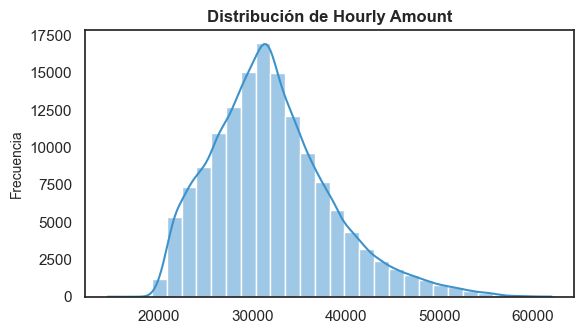

In [8]:
# Use a consistent style
sns.set_theme(style="white")

cc_hourly_data_columns = cc_hourly_data.select_dtypes(include=['float64', 'int64']).columns

for col in cc_hourly_data_columns:
    plt.figure(figsize=(6, 3.5))  # Slightly larger for readability
    sns.histplot(cc_hourly_data[col], kde=True, bins=30, color="#3E92CC", edgecolor="white")
    
    # Add nicer formatting
    plt.title(f"Distribución de {col}", fontsize=12, weight='bold')
    plt.gca().set_xlabel(None)
    plt.ylabel("Frecuencia", fontsize=10)
    
    # Optional: tighter layout
    plt.tight_layout()
    plt.show()

In [9]:
cc_hourly_data = cc_hourly_data['Hourly Amount']

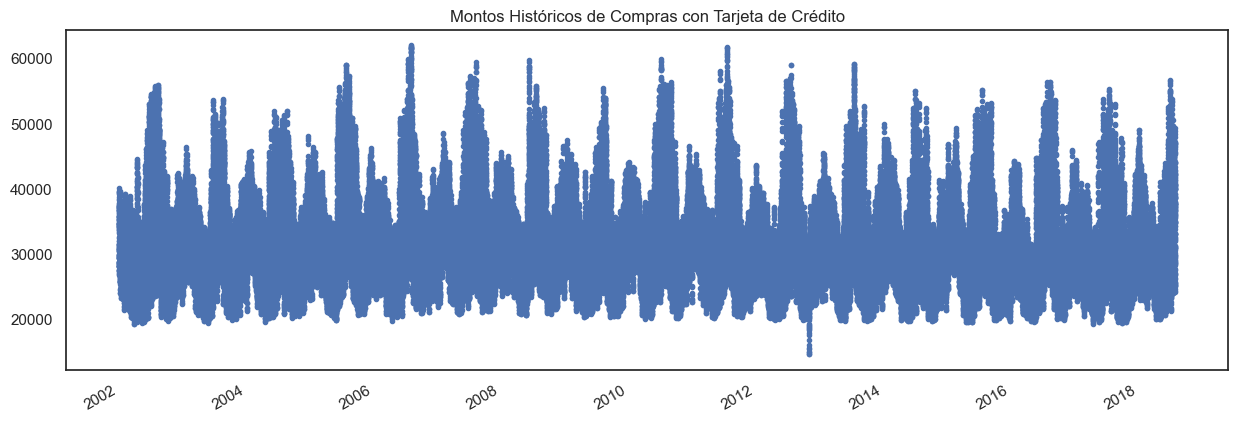

In [10]:
_ = cc_hourly_data.plot(
    style = '.',
    figsize = (15,5),
    title = 'Montos Históricos de Compras con Tarjeta de Crédito'
)

plt.gca().set_xlabel(None)
plt.show()

## Split data

In [11]:
split_date = '01-Jan-2015'

cc_hourly_data_train = cc_hourly_data.loc[cc_hourly_data.index <= split_date].copy()
cc_hourly_data_test = cc_hourly_data.loc[cc_hourly_data.index > split_date].copy()

cc_hourly_data_test = cc_hourly_data_test.to_frame()
cc_hourly_data_train = cc_hourly_data_train.to_frame()

print(cc_hourly_data_train)
print(cc_hourly_data_test)

                     Hourly Amount
Datetime                          
2002-12-31 01:00:00        26498.0
2002-12-31 02:00:00        25147.0
2002-12-31 03:00:00        24574.0
2002-12-31 04:00:00        24393.0
2002-12-31 05:00:00        24860.0
...                            ...
2014-01-01 20:00:00        36193.0
2014-01-01 21:00:00        35601.0
2014-01-01 22:00:00        34242.0
2014-01-01 23:00:00        32215.0
2014-01-02 00:00:00        30159.0

[113927 rows x 1 columns]
                     Hourly Amount
Datetime                          
2015-12-31 01:00:00        24305.0
2015-12-31 02:00:00        23156.0
2015-12-31 03:00:00        22514.0
2015-12-31 04:00:00        22330.0
2015-12-31 05:00:00        22773.0
...                            ...
2018-01-01 20:00:00        44284.0
2018-01-01 21:00:00        43751.0
2018-01-01 22:00:00        42402.0
2018-01-01 23:00:00        40164.0
2018-01-02 00:00:00        38608.0

[31439 rows x 1 columns]


In [12]:
type(cc_hourly_data_test)
type(cc_hourly_data_train)

pandas.core.frame.DataFrame

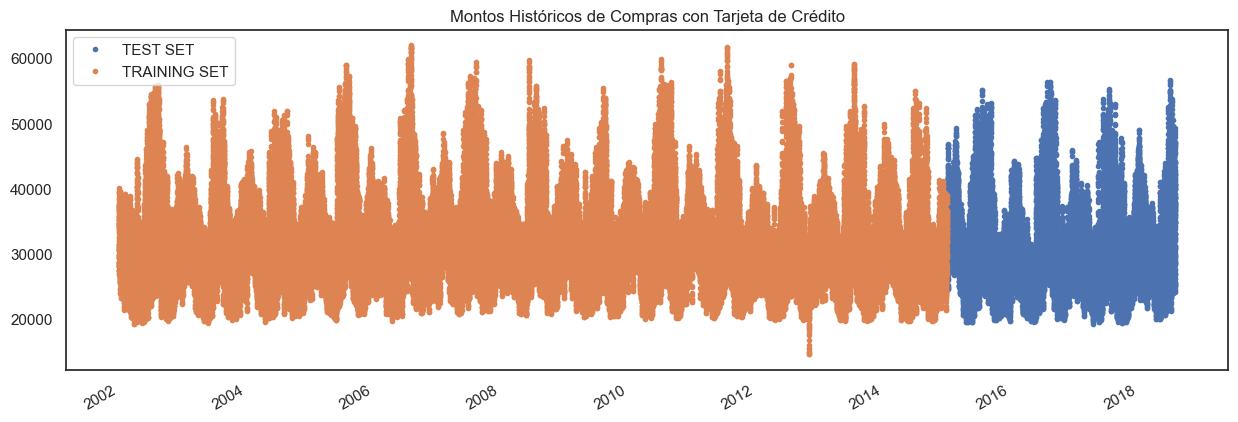

In [13]:
_ = cc_hourly_data_test \
    .rename(columns = {'Hourly Amount': 'TEST SET'}) \
    .join(cc_hourly_data_train.rename(columns = { 'Hourly Amount': 'TRAINING SET' }), how = 'outer') \
    .plot(figsize = (15, 5), title = 'Montos Históricos de Compras con Tarjeta de Crédito', style = '.')

plt.gca().set_xlabel(None)
plt.show()

## Prepare data for Forcasting

In [14]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]

        return X, y
    
    return X

In [15]:
cc_hourly_X_train, cc_hourly_y_train = create_features(cc_hourly_data_train, label = 'Hourly Amount')
cc_hourly_X_test, cc_hourly_y_test = create_features(cc_hourly_data_test, label = 'Hourly Amount')

In [16]:
cc_hourly_X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


In [17]:
cc_hourly_X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,4,3,4,12,2015,365,31,53
2015-12-31 05:00:00,5,3,4,12,2015,365,31,53


In [18]:
cc_hourly_y_train.head()

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: Hourly Amount, dtype: float64

In [19]:
cc_hourly_y_test.head()

Datetime
2015-12-31 01:00:00    24305.0
2015-12-31 02:00:00    23156.0
2015-12-31 03:00:00    22514.0
2015-12-31 04:00:00    22330.0
2015-12-31 05:00:00    22773.0
Name: Hourly Amount, dtype: float64

## XGBoost model

In [20]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [21]:
cc_hourly_xgboost_model = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50)

cc_hourly_xgboost_model.fit(
    cc_hourly_X_train, cc_hourly_y_train,
    eval_set = [(cc_hourly_X_train, cc_hourly_y_train), (cc_hourly_X_test, cc_hourly_y_test)],
    verbose = True
)

cc_hourly_xgboost_model

[0]	validation_0-rmse:5178.20659	validation_1-rmse:5362.58699
[1]	validation_0-rmse:4381.36190	validation_1-rmse:4701.24012
[2]	validation_0-rmse:3875.94540	validation_1-rmse:4291.42311
[3]	validation_0-rmse:3568.61653	validation_1-rmse:4100.19117
[4]	validation_0-rmse:3386.60370	validation_1-rmse:3984.47407
[5]	validation_0-rmse:3235.37054	validation_1-rmse:3900.92655
[6]	validation_0-rmse:3139.99310	validation_1-rmse:3880.43917
[7]	validation_0-rmse:3050.64640	validation_1-rmse:3810.32224
[8]	validation_0-rmse:3008.72051	validation_1-rmse:3777.52114
[9]	validation_0-rmse:2949.06175	validation_1-rmse:3756.20242
[10]	validation_0-rmse:2919.69527	validation_1-rmse:3749.04384
[11]	validation_0-rmse:2837.28993	validation_1-rmse:3772.71643
[12]	validation_0-rmse:2803.01698	validation_1-rmse:3807.39750
[13]	validation_0-rmse:2740.07411	validation_1-rmse:3841.05399
[14]	validation_0-rmse:2708.28013	validation_1-rmse:3873.14074
[15]	validation_0-rmse:2678.86325	validation_1-rmse:3922.42404
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
# Predict with test data
cc_hourly_xgboost_forecast = cc_hourly_xgboost_model.predict(cc_hourly_X_test)

# Calculate metrics
cc_hourly_xgboost_mae = mean_absolute_error(cc_hourly_y_test, cc_hourly_xgboost_forecast)
cc_hourly_xgboost_mse = mean_squared_error(cc_hourly_y_test, cc_hourly_xgboost_forecast)
cc_hourly_xgboost_mape = mean_absolute_percentage_error(cc_hourly_y_test, cc_hourly_xgboost_forecast)

print(f"MAE: { cc_hourly_xgboost_mae }")
print(f"MSE: { cc_hourly_xgboost_mse }")
print(f"MAPE: { cc_hourly_xgboost_mape }")

MAE: 2905.541158635075
MSE: 14055329.714256588
MAPE: 0.09239324261253785


In [23]:
cc_hourly_xgboost_forecast

array([28465.666, 27514.092, 27331.955, ..., 38293.902, 35941.176,
       32676.645], dtype=float32)

In [24]:
cc_hourly_data_test

,Hourly Amount,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53
2015-12-31 05:00:00,22773.0,2015-12-31 05:00:00,5,3,4,12,2015,365,31,53
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,1,1,2018,1,1,1


In [25]:
cc_hourly_data_test['HA_XGBOOST_Prediction'] = cc_hourly_xgboost_forecast

cc_hourly_data_test

,Hourly Amount,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,HA_XGBOOST_Prediction
Datetime,,,,,,,,,,,
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53,28465.666016
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53,27514.091797
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53,27331.955078
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53,27331.955078
2015-12-31 05:00:00,22773.0,2015-12-31 05:00:00,5,3,4,12,2015,365,31,53,27518.978516
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,39341.148438
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,39095.214844
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,38293.902344


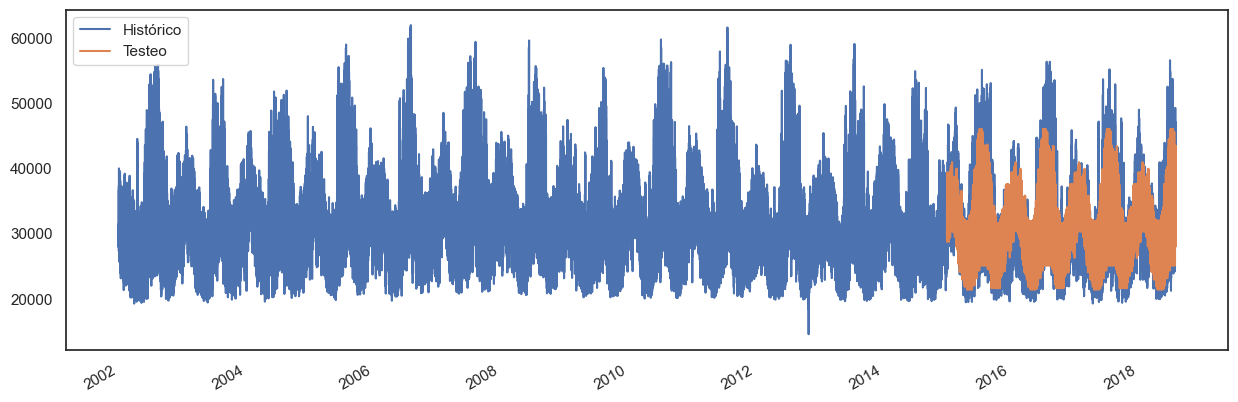

In [26]:
cc_hourly_xgboost_all = pd.concat([cc_hourly_data_test, cc_hourly_data_train], sort=False)

_ = cc_hourly_xgboost_all[['Hourly Amount','HA_XGBOOST_Prediction']] \
    .rename(
        columns = {
        'Hourly Amount': 'Histórico',
        'HA_XGBOOST_Prediction': 'Testeo'
        }
    ) \
    .plot(figsize=(15, 5))

plt.gca().set_xlabel(None)
plt.show()

In [27]:
cc_hourly_last_date = cc_hourly_data_test.index.max()

cc_hourly_last_date

Timestamp('2018-08-03 00:00:00')

In [28]:
# Create a future dataframe with hourly datetime index from 2018-08-03 to 2025
cc_hourly_future_dates = pd.date_range(
    start = cc_hourly_last_date,
    end = '2025-12-31 23:00:00',
    freq = 'H'
)

cc_hourly_future_data = pd.DataFrame(index = cc_hourly_future_dates)

cc_hourly_future_data.head()

""
2018-08-03 00:00:00
2018-08-03 01:00:00
2018-08-03 02:00:00
2018-08-03 03:00:00
2018-08-03 04:00:00


In [29]:
# Generate features for the future dataframe
cc_hourly_future_features = create_features(cc_hourly_future_data)

# Predict the CC_HA values for the future dataframe
cc_hourly_future_forcasting = cc_hourly_xgboost_model.predict(cc_hourly_future_features)

# Add the predictions to the future dataframe
cc_hourly_future_data['CC_HA_XGBOOST_Prediction'] = cc_hourly_future_forcasting

# Display the future dataframe with predictions
cc_hourly_future_data.head()

,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,CC_HA_XGBOOST_Prediction
2018-08-03 00:00:00,2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,33064.902344
2018-08-03 01:00:00,2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,31032.207031
2018-08-03 02:00:00,2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,28512.712891
2018-08-03 03:00:00,2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,27971.130859
2018-08-03 04:00:00,2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,27971.130859


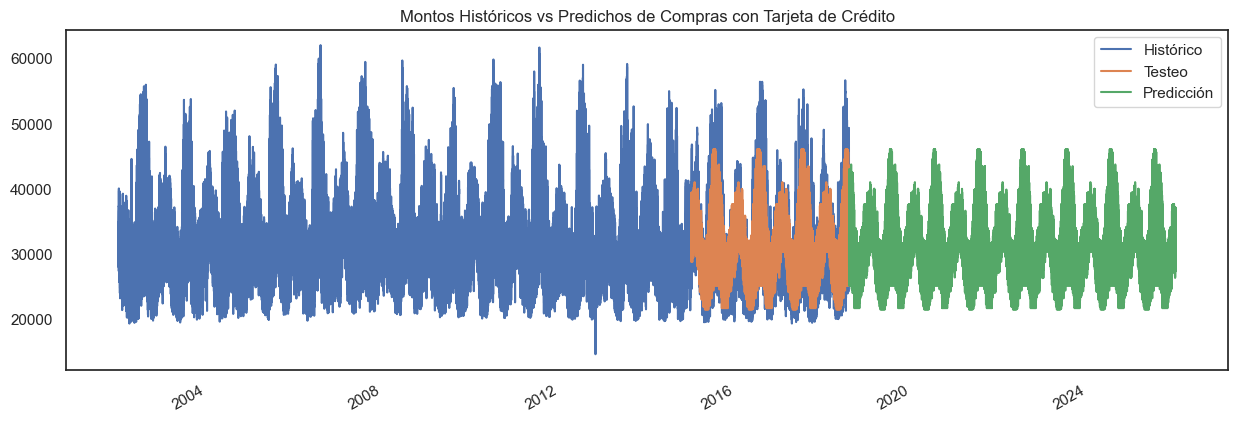

In [30]:
# Add future predictions to the combined dataframe
cc_hourly_all = pd.concat([cc_hourly_data_test, cc_hourly_data_train, cc_hourly_future_data], sort=False)

# Plot the actual and predicted values including future predictions
_ = cc_hourly_all[['Hourly Amount', 'HA_XGBOOST_Prediction', 'CC_HA_XGBOOST_Prediction']]\
    .rename(columns = {
        'Hourly Amount': 'Histórico',
        'HA_XGBOOST_Prediction': 'Testeo',
        'CC_HA_XGBOOST_Prediction': 'Predicción'
    }) \
    .plot(figsize = (15, 5), title = 'Montos Históricos vs Predichos de Compras con Tarjeta de Crédito')

In [31]:
cc_hourly_data_train

,Hourly Amount,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,36193.0,2014-01-01 20:00:00,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,35601.0,2014-01-01 21:00:00,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,34242.0,2014-01-01 22:00:00,22,2,1,1,2014,1,1,1


In [32]:
cc_hourly_future_data

,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,CC_HA_XGBOOST_Prediction
2018-08-03 00:00:00,2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,33064.902344
2018-08-03 01:00:00,2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,31032.207031
2018-08-03 02:00:00,2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,28512.712891
2018-08-03 03:00:00,2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,27971.130859
2018-08-03 04:00:00,2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,27971.130859
...,...,...,...,...,...,...,...,...,...,...
2025-12-31 19:00:00,2025-12-31 19:00:00,19,2,4,12,2025,365,31,1,37070.996094
2025-12-31 20:00:00,2025-12-31 20:00:00,20,2,4,12,2025,365,31,1,37070.996094
2025-12-31 21:00:00,2025-12-31 21:00:00,21,2,4,12,2025,365,31,1,36955.359375
2025-12-31 22:00:00,2025-12-31 22:00:00,22,2,4,12,2025,365,31,1,36389.652344


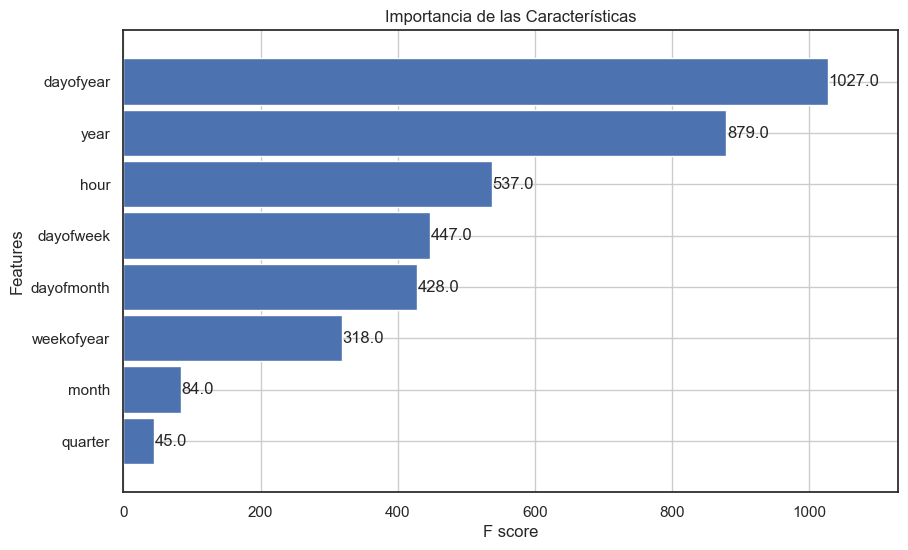

In [33]:
_ = plot_importance(cc_hourly_xgboost_model, height=0.9) \
    .set_title('Importancia de las Características')

# increase width of the plot
plt.gcf().set_size_inches(10, 6)

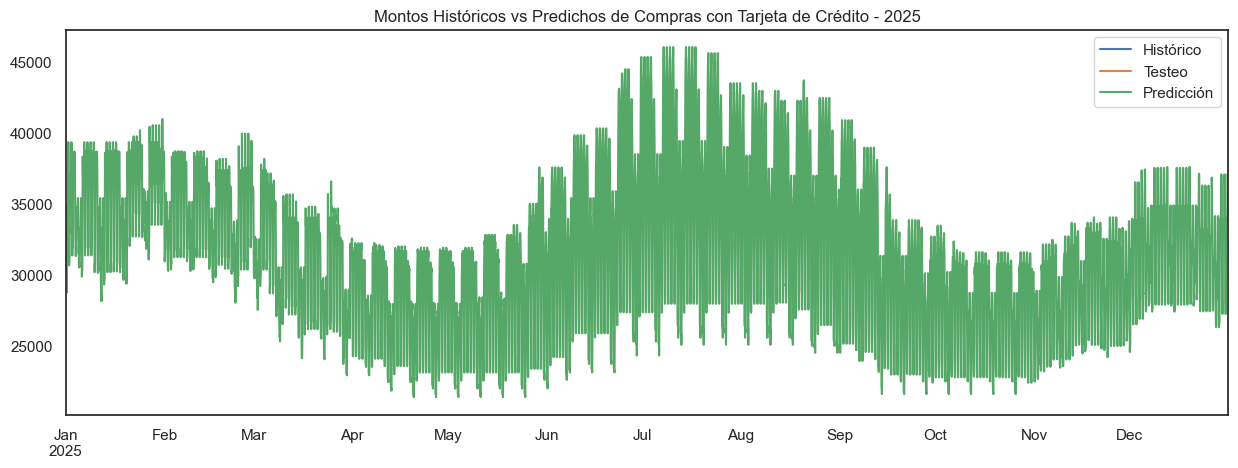

In [34]:
# Filter data for the year 2025
cc_2025 = cc_hourly_all.loc['2025']

# Plot actual and predicted values for 2025
_ = cc_2025[['Hourly Amount', 'HA_XGBOOST_Prediction', 'CC_HA_XGBOOST_Prediction']]\
    .rename(columns={
        'Hourly Amount': 'Histórico',
        'HA_XGBOOST_Prediction': 'Testeo',
        'CC_HA_XGBOOST_Prediction': 'Predicción'
    }) \
    .plot(figsize=(15, 5), title='Montos Históricos vs Predichos de Compras con Tarjeta de Crédito - 2025')

plt.gca().set_xlabel(None)
plt.show()